In [1]:
import os
import json

import cv2 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
SEED = 42

BBOX_MARGIN = .2
TIME_STAMP = '2021_04_29'

ITASCA_PATH = '/home/ubuntu/percepto/data/ItascaClassification'
IMAGE_PATH = os.path.join(ITASCA_PATH, 'dataset', 'images')
RAW_IMAGES_PATH = os.path.join(IMAGE_PATH, 'raw')
MASKS_PATH = os.path.join(ITASCA_PATH, 'dataset', 'annotations')
CROPPED_PATH = os.path.join(IMAGE_PATH, 'cropped')
JSON_PATH = os.path.join(ITASCA_PATH, 'in_progress')
MAPPING_PATH = os.path.join(ITASCA_PATH, 'dataset', 'mapping', TIME_STAMP)

MAPPING_DICT = {'leak': 2000, 
               'fire': 2001, 
               'gnome': 2002}

In [3]:
sorted(os.listdir(RAW_IMAGES_PATH))[:5]

['`.jpg',
 'itasca-camera-105_ptz_2020-04-03T21_04_13.895Z.jpg',
 'itasca-camera-105_ptz_2020-04-03T21_34_28.246Z.jpg',
 'itasca-camera-105_ptz_2020-04-07T20_00_49.449Z.jpg',
 'itasca-camera-105_ptz_2020-05-05T13_03_48.931Z.jpg']

In [58]:
sorted(os.listdir(MASKS_PATH))[:5]

['`.jpg___fuse.png',
 'classes',
 'itasca-camera-105_ptz_2020-04-03T21_04_13.895Z.jpg___fuse.png',
 'itasca-camera-105_ptz_2020-04-03T21_34_28.246Z.jpg___fuse.png',
 'itasca-camera-105_ptz_2020-04-07T20_00_49.449Z.jpg___fuse.png']

In [5]:
sorted(os.listdir(JSON_PATH))[:5]

['`.jpg___pixel.json',
 'itasca-camera-105_ptz_2020-04-03T21_04_13.895Z.jpg___pixel.json',
 'itasca-camera-105_ptz_2020-04-03T21_34_28.246Z.jpg___pixel.json',
 'itasca-camera-105_ptz_2020-04-07T20_00_49.449Z.jpg___pixel.json',
 'itasca-camera-105_ptz_2020-05-05T13_03_48.931Z.jpg___pixel.json']

In [6]:
len(list(filter(lambda s: s.endswith('jpg'), os.listdir(RAW_IMAGES_PATH))))

355

149


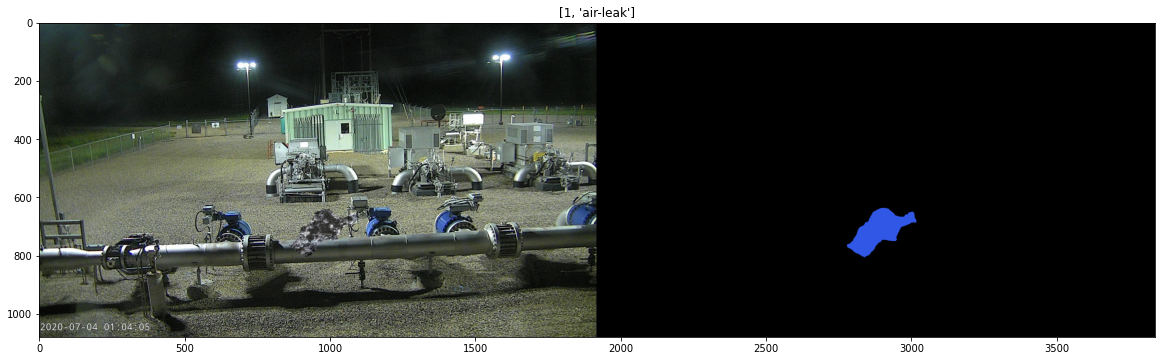

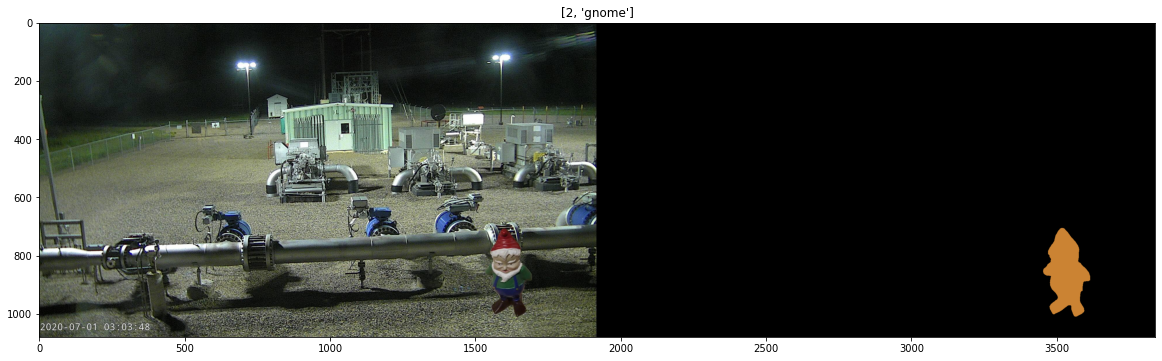

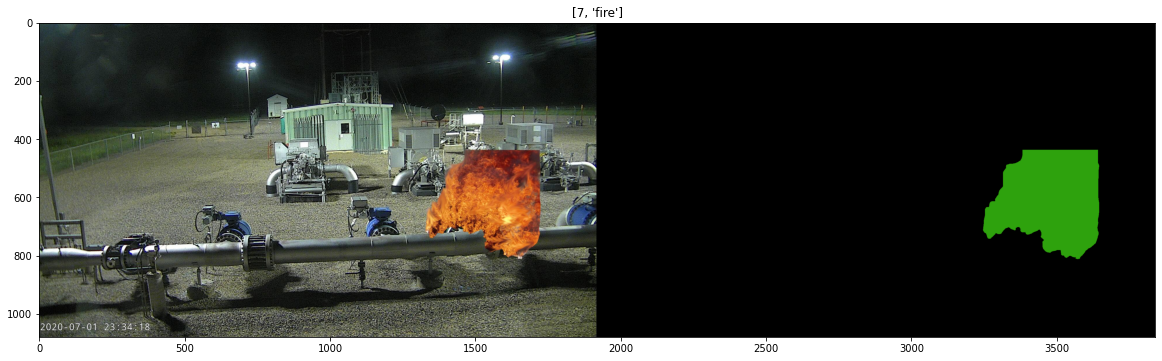

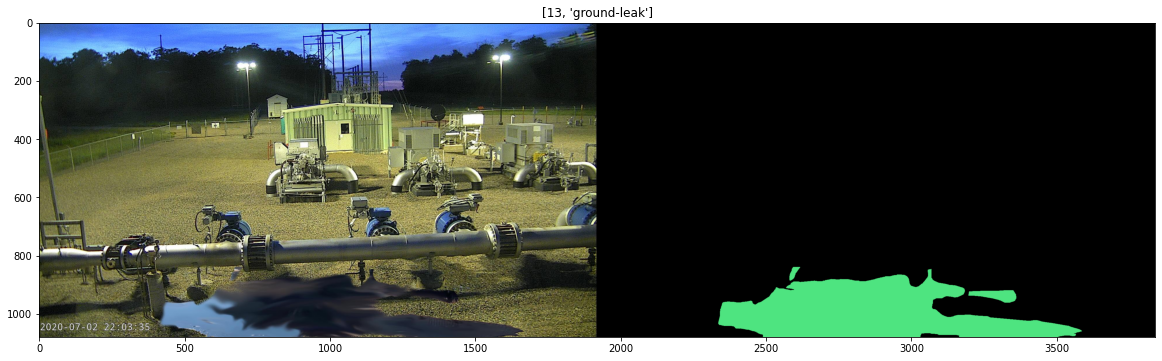

In [7]:
i = 0

class_set = set()

for file in os.listdir(RAW_IMAGES_PATH):
    
    image_path = os.path.join(RAW_IMAGES_PATH, file)
    json_file = os.path.join(JSON_PATH, f'{file}___pixel.json')
    mask_path = os.path.join(MASKS_PATH, f'{file}___fuse.png')

    with open(json_file) as jf:
        data = json.load(jf)
    if len(data['instances']) and (data['instances'][0]['className'] != 'semantic_change'):
        i += 1

        class_name = data['instances'][0]['className']

        if class_name not in class_set:
            class_set.add(class_name)
            image = cv2.imread(image_path)
            mask = cv2.imread(mask_path)

            plt.figure(figsize=(20, 10))
            plt.imshow(np.hstack([image[...,::-1], mask]))
            plt.title([i, data['instances'][0]['className']])
print(i)

In [8]:
def crop_out_of_bounds(img, bbox):
    """crops an image when bounding box can be out of image bounderies"""
    
    h, w = img.shape[:2]
    x, y, dx, dy = bbox
    
    tmp_crop = img[max(0, y):y+dy, max(0, x):x+dx].copy()
    cropped = np.zeros((dy, dx, 3), dtype='uint8')
    cropped[abs(min(0, y)):h-y, abs(min(0, x)):w-x] = tmp_crop
    
    return cropped    

In [51]:
i = 0

files_list = []
mapping_list = []
classes_list = []
bbox_list = []

crop_ext = f'_cropped_{BBOX_MARGIN}.jpg'

for file in os.listdir(RAW_IMAGES_PATH):

    image_path = os.path.join(RAW_IMAGES_PATH, file)
    json_file = os.path.join(JSON_PATH, f'{file}___pixel.json')
    mask_path = os.path.join(MASKS_PATH, f'{file}___fuse.png')
    
    with open(json_file) as jf:
        data = json.load(jf)
        
    if len(data['instances']) and (data['instances'][0]['className'] != 'semantic_change'):
        i += 1

        class_name = data['instances'][0]['className'].split('-')[-1]

        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(mask,127,255,2)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        max_area = 0 
        for c in contours:
            area = cv2.contourArea(c)
            if area > max_area:
                cnt = c
                max_area = area

        x, y, w, h = cv2.boundingRect(cnt)

        dw = int(BBOX_MARGIN * w)
        dh = int(BBOX_MARGIN * h)
        cropped_img = crop_out_of_bounds(image, (x-dw, y-dh, w+2*dw, h+2*dh))

        cropped_path = file.replace('.jpg', crop_ext)
        cv2.imwrite(os.path.join(CROPPED_PATH, cropped_path), cropped_img)

        files_list.append(f'images/cropped/{cropped_path}')
        mapping_list.append(f'annotations/{cropped_path.replace("jpg", "txt")}')
        classes_list.append(MAPPING_DICT[class_name])
        bbox_list.append([dw, dh, w, h])

        if i < 5:
#             cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 5)
#             cv2.rectangle(image, (x-dw, y-dh), (x+w+dw, y+h+dh), (0, 0, 255), 5)

#             plt.figure(figsize=(10, 7))
#             plt.subplot(1, 2 ,1)
#             plt.imshow(image[...,::-1])
#             plt.subplot(1, 2 ,2)
#             plt.imshow(cropped[...,::-1])

#             plt.title([i, data['instances'][0]['className'], len(contours)])
            pass
        else:
            break




In [53]:

df = pd.concat([pd.DataFrame(list(zip(files_list, mapping_list, classes_list)), 
                             columns =['image_name', 'mapping_file', 'class']),
                pd.DataFrame(data={'A': 1, 'B': 0, 'C': 0}, index=np.arange(len(files_list))),
                pd.DataFrame(bbox_list, columns =['x', 'y', 'w', 'h'])], 
               axis=1)




print(df.head())
                


                                          image_name  \
0  images/cropped/itasca-camera-105_ptz_2020-07-0...   
1  images/cropped/itasca-camera-105_ptz_2020-07-0...   
2  images/cropped/itasca-camera-105_ptz_2020-07-0...   
3  images/cropped/itasca-camera-105_ptz_2020-07-0...   
4  images/cropped/itasca-camera-105_ptz_2020-07-0...   

                                        mapping_file  class  A  B  C   x   y  \
0  annotations/itasca-camera-105_ptz_2020-07-04T0...   2000  1  0  0  48  34   
1  annotations/itasca-camera-105_ptz_2020-07-01T0...   2002  1  0  0  32  61   
2  annotations/itasca-camera-105_ptz_2020-07-01T1...   2002  1  0  0  32  61   
3  annotations/itasca-camera-105_ptz_2020-07-01T1...   2002  1  0  0  32  61   
4  annotations/itasca-camera-105_ptz_2020-07-03T1...   2000  1  0  0  48  33   

     w    h  
0  240  170  
1  162  305  
2  164  307  
3  164  308  
4  242  166  


In [54]:
list(df.image_name)

['images/cropped/itasca-camera-105_ptz_2020-07-04T06_04_11.005Z_cropped_0.2.jpg',
 'images/cropped/itasca-camera-105_ptz_2020-07-01T08_03_53.739Z_cropped_0.2.jpg',
 'images/cropped/itasca-camera-105_ptz_2020-07-01T14_34_17.292Z_cropped_0.2.jpg',
 'images/cropped/itasca-camera-105_ptz_2020-07-01T13_54_10.212Z_cropped_0.2.jpg',
 'images/cropped/itasca-camera-105_ptz_2020-07-03T19_34_02.765Z_cropped_0.2.jpg']

In [55]:
list(df.mapping_file)

['annotations/itasca-camera-105_ptz_2020-07-04T06_04_11.005Z_cropped_0.2.txt',
 'annotations/itasca-camera-105_ptz_2020-07-01T08_03_53.739Z_cropped_0.2.txt',
 'annotations/itasca-camera-105_ptz_2020-07-01T14_34_17.292Z_cropped_0.2.txt',
 'annotations/itasca-camera-105_ptz_2020-07-01T13_54_10.212Z_cropped_0.2.txt',
 'annotations/itasca-camera-105_ptz_2020-07-03T19_34_02.765Z_cropped_0.2.txt']

In [ ]:
df['class'].value_counts()

In [ ]:
train, val = train_test_split(df, random_state=SEED, stratify=df['class'])

In [ ]:
train['class'].value_counts()

In [ ]:
val['class'].value_counts()

In [ ]:
train.to_csv(os.path.join(MAPPING_PATH, 'train.txt'), index=False, header=False)
val.to_csv(os.path.join(MAPPING_PATH, 'val.txt'), index=False, header=False)

In [ ]:
# ! rm -r {ROW_DATA_PATH} {CROPPED_PATH} {MAPPING_PATH}